# Crowdsourced mapping dataset from UCI-ML repo

[This dataset]('https://archive.ics.uci.edu/ml/datasets/Crowdsourced+Mapping') was derived from geospatial data from two sources: 
1. Landsat time-series satellite imagery from the years 2014-2015
2. crowdsourced georeferenced polygons with land cover labels obtained from OpenStreetMap. 

The crowdsourced polygons cover only a small part of the image area, and are used used to extract training data from the image for classifying the rest of the image. The main challenge with the dataset is that both the imagery and the crowdsourced data contain noise (due to cloud cover in the images and innaccurate labeling/digitizing of polygons).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pycaret
import matplotlib

%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 13

1. **class**: The land cover class (impervious, farm, forest, grass, orchard, water) [note: this is the target variable to classify].
2. **max_ndvi**: the maximum NDVI (normalized difference vegetation index) value derived from the time-series of satellite images.
3. **20150720_N - 20140101_N** : NDVI values extracted from satellite images acquired between January 2014 and July 2015, in reverse chronological order (dates given in the format yyyymmdd).

In [2]:
train = pd.read_csv('training.csv')
test = pd.read_csv('testing.csv')

Reverse the columns in `train` and `test` dataset, to shift the target column to the end

In [3]:
train = train.loc[:, ::-1]
test = test.loc[:, ::-1]
print(train.shape, test.shape)
train = pd.concat([train, test], axis=0)
print(train.shape)
train.head(5)

(10545, 29) (300, 29)
(10845, 29)


,20140101_N,20140117_N,20140202_N,20140218_N,20140322_N,20140407_N,20140423_N,20140509_N,20140525_N,20140610_N,...,20150226_N,20150314_N,20150330_N,20150415_N,20150501_N,20150517_N,20150602_N,20150720_N,max_ndvi,class
0,433.906,-1180.190,-2203.02,211.328,452.238,366.608,267.138,-1942.490,-1043.160,-921.193,...,-1628.240,630.087,-1739.990,997.904,-1924.36,-1882.030,658.668,637.5950,997.904,water
1,524.075,-1360.560,-2250.00,220.878,476.972,364.858,120.059,-625.385,-933.934,-954.719,...,-1670.590,707.626,-692.386,914.198,-1672.32,-1625.790,593.705,634.2400,914.198,water
2,3800.810,150.931,2762.57,293.730,300.560,385.203,1056.600,2208.440,1566.160,1562.210,...,849.599,214.564,1077.840,546.371,1071.21,449.735,1206.880,1671.3400,3800.810,water
3,-1343.550,600.359,-2202.12,369.214,291.336,304.621,-1227.800,-1786.950,368.622,-1025.880,...,729.790,-858.390,-1564.630,578.807,-1052.63,210.714,-1599.160,58.0174,952.178,water
4,-826.727,626.379,-2197.36,298.320,282.833,432.150,-924.073,-1189.710,155.624,-1813.950,...,683.254,-802.942,-1413.180,515.805,-1256.93,380.436,-1220.880,72.5180,1232.120,water


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10845 entries, 0 to 299
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   20140101_N  10845 non-null  float64
 1   20140117_N  10845 non-null  float64
 2   20140202_N  10845 non-null  float64
 3   20140218_N  10845 non-null  float64
 4   20140322_N  10845 non-null  float64
 5   20140407_N  10845 non-null  float64
 6   20140423_N  10845 non-null  float64
 7   20140509_N  10845 non-null  float64
 8   20140525_N  10845 non-null  float64
 9   20140610_N  10845 non-null  float64
 10  20140626_N  10845 non-null  float64
 11  20140813_N  10845 non-null  float64
 12  20140930_N  10845 non-null  float64
 13  20141016_N  10845 non-null  float64
 14  20141101_N  10845 non-null  float64
 15  20141117_N  10845 non-null  float64
 16  20150109_N  10845 non-null  float64
 17  20150125_N  10845 non-null  float64
 18  20150210_N  10845 non-null  float64
 19  20150226_N  10845 non-null 

In [5]:
train.describe()

,20140101_N,20140117_N,20140202_N,20140218_N,20140322_N,20140407_N,20140423_N,20140509_N,20140525_N,20140610_N,...,20150210_N,20150226_N,20150314_N,20150330_N,20150415_N,20150501_N,20150517_N,20150602_N,20150720_N,max_ndvi
count,10845.000000,10845.000000,10845.000000,10845.000000,10845.000000,10845.000000,10845.000000,10845.000000,10845.000000,10845.000000,...,10845.000000,10845.000000,10845.000000,10845.000000,10845.000000,10845.000000,10845.000000,10845.000000,10845.000000,10845.000000
mean,2566.613900,2564.274632,6071.186700,2041.965505,2669.581329,2030.725088,3011.825105,3022.588646,3633.226888,4758.548958,...,4224.971202,4871.459511,3337.935688,4883.596688,2862.763558,5046.640099,4337.641928,4766.589523,5694.503074,7254.097497
std,2433.747341,2345.362697,2023.982802,2200.256861,2398.929476,2013.867923,2187.013375,2068.619041,2303.755746,2757.952570,...,2793.572913,2719.822352,2440.250661,2597.452840,2674.749946,2531.963833,2878.973787,2746.093877,2306.413728,1639.115094
min,-4723.980000,-4550.190000,-6807.550000,-232.292000,-4354.630000,-2853.890000,-4212.560000,-4869.010000,-3257.730000,-3991.910000,...,-6000.000000,-5604.450000,-3520.840000,-5992.080000,-3232.180000,-5355.400000,-5774.370000,-3345.120000,-3363.640000,338.410000
25%,682.089000,689.898000,5605.260000,493.462000,758.502000,429.634000,1007.320000,1403.430000,1397.790000,1991.110000,...,1381.880000,2298.310000,1016.990000,2442.650000,526.384000,2944.310000,1437.920000,2057.630000,4004.240000,7262.770000
50%,1460.780000,1506.570000,6853.680000,930.116000,1509.160000,1253.860000,2621.700000,2672.840000,3598.150000,5221.170000,...,4241.970000,5642.170000,2889.600000,5629.480000,1589.470000,5550.980000,4379.600000,5258.050000,6726.560000,7878.820000
75%,4159.290000,4221.210000,7377.720000,2891.180000,4437.570000,2980.640000,4827.940000,4189.810000,5809.840000,7531.100000,...,7127.670000,7382.790000,5533.490000,7244.090000,5439.440000,7425.560000,7298.430000,7480.000000,7583.520000,8117.400000
max,8502.020000,8418.230000,8410.330000,8247.630000,8235.400000,8206.780000,7919.070000,8445.410000,7981.820000,8489.970000,...,8422.060000,8452.380000,8001.700000,8499.330000,8267.120000,8516.100000,8650.500000,8566.420000,8377.720000,8650.500000


## Exploratory Data Analysis


Change col names to `pd.DateTime`

In [6]:
original_cols = list(train.columns)[:-2]
original_format = '%Y%m%d_N'
datetime_columns = [datetime.datetime.strptime(col, original_format).strftime('%Y-%m-%d') for col in original_cols]

train.columns = datetime_columns + ['max_ndvi', 'class']
test.columns = datetime_columns + ['max_ndvi', 'class']

train.head()

,2014-01-01,2014-01-17,2014-02-02,2014-02-18,2014-03-22,2014-04-07,2014-04-23,2014-05-09,2014-05-25,2014-06-10,...,2015-02-26,2015-03-14,2015-03-30,2015-04-15,2015-05-01,2015-05-17,2015-06-02,2015-07-20,max_ndvi,class
0,433.906,-1180.190,-2203.02,211.328,452.238,366.608,267.138,-1942.490,-1043.160,-921.193,...,-1628.240,630.087,-1739.990,997.904,-1924.36,-1882.030,658.668,637.5950,997.904,water
1,524.075,-1360.560,-2250.00,220.878,476.972,364.858,120.059,-625.385,-933.934,-954.719,...,-1670.590,707.626,-692.386,914.198,-1672.32,-1625.790,593.705,634.2400,914.198,water
2,3800.810,150.931,2762.57,293.730,300.560,385.203,1056.600,2208.440,1566.160,1562.210,...,849.599,214.564,1077.840,546.371,1071.21,449.735,1206.880,1671.3400,3800.810,water
3,-1343.550,600.359,-2202.12,369.214,291.336,304.621,-1227.800,-1786.950,368.622,-1025.880,...,729.790,-858.390,-1564.630,578.807,-1052.63,210.714,-1599.160,58.0174,952.178,water
4,-826.727,626.379,-2197.36,298.320,282.833,432.150,-924.073,-1189.710,155.624,-1813.950,...,683.254,-802.942,-1413.180,515.805,-1256.93,380.436,-1220.880,72.5180,1232.120,water


6 classes of target variable are are:  ['water' 'forest' 'impervious' 'farm' 'grass' 'orchard']


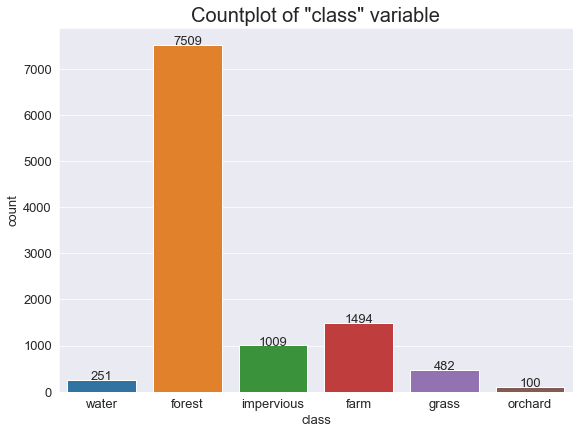

In [7]:
print("6 classes of target variable are are: ", train['class'].unique())

plt.figure(figsize=(8,6))
plt.title('Countplot of "class" variable', fontsize=20)
plt.tight_layout()
ax = sns.countplot(train['class'])
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()+1), ha='center')
# plt.savefig('test_countplot.png')

In [8]:
orchard_df = train.loc[train['class'] == 'orchard', ['max_ndvi', 'class']]
display(orchard_df.head())
display(orchard_df.describe())

plt.figure(figsize=(15,6))
x_toplot = orchard_df['max_ndvi'][::2].index
y_toplot = orchard_df['max_ndvi'][::2]
ax = sns.barplot(y=y_toplot, x=x_toplot, color="#2E8540")
# ax = sns.histplot(y_toplot, kde=True)
ax.axhline(y=y_toplot.mean(), color='red', linestyle='--', label='Mean')
ax.annotate('Mean: {:.2f}'.format(y_toplot.mean()), xy=(0.5, y_toplot.mean()), xytext=(29, y_toplot.mean()+100), color='red', fontsize=12)
ax.legend(loc='best')
plt.title('Plotting all barplots of max_ndvi for class: orchard in intervals of 2', fontsize=20)
plt.xlabel('Index values')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('orchard.png')

,max_ndvi,class
8205,8173.24,orchard
8490,7929.62,orchard
9104,7084.41,orchard
9105,7356.68,orchard
9106,6982.08,orchard


,max_ndvi
count,100.000000
mean,7707.225200
std,608.951844
min,4013.330000
25%,7616.557500
50%,7864.345000
75%,8041.917500
max,8416.930000


In [ ]:
water_df = train.loc[train['class'] == 'water', ['max_ndvi', 'class']]
display(water_df.head())
display(water_df.describe())

plt.figure(figsize=(15,6))
x_toplot = water_df['max_ndvi'][::5].index
y_toplot = water_df['max_ndvi'][::5]
ax = sns.barplot(y=y_toplot, x=x_toplot, color="#2E8540")
# ax = sns.histplot(y_toplot, kde=True)
ax.axhline(y=y_toplot.mean(), color='red', linestyle='--', label='Mean')
ax.annotate('Mean: {:.2f}'.format(y_toplot.mean()), xy=(0.5, y_toplot.mean()), xytext=(25, y_toplot.mean()+100), color='red', fontsize=12)
ax.legend(loc='best')
plt.title('Plotting all barplots of max_ndvi for class: water in intervals of 5', fontsize=20)
plt.xlabel('Index values in intervals of 5')
plt.xticks(rotation=90)
plt.tight_layout()
# xticks = [0, 204] 
# ax.set_xticks(xticks);
plt.savefig('water.png')

In [ ]:
grass_df = train.loc[train['class'] == 'grass', ['max_ndvi', 'class']]
display(grass_df.head())
display(grass_df.describe())

plt.figure(figsize=(15,6))
x_toplot = grass_df['max_ndvi'][::10].index
y_toplot = grass_df['max_ndvi'][::10]
ax = sns.barplot(y=y_toplot, x=x_toplot, color="#2E8540")
# ax = sns.histplot(y_toplot, kde=True)
ax.axhline(y=y_toplot.mean(), color='red', linestyle='--', label='Mean')
ax.annotate('Mean: {:.2f}'.format(y_toplot.mean()), xy=(0.5, y_toplot.mean()), xytext=(7, y_toplot.mean()+100), color='red', fontsize=12)
ax.legend(loc='best')
plt.title('Plotting all barplots of max_ndvi for class: grass in intervals of 10', fontsize=20)
plt.xlabel('Index values in intervals of 10')
plt.tight_layout()
plt.xticks(rotation=90);
# plt.savefig('grass.png')

In [ ]:
impervious_df = train.loc[train['class'] == 'impervious', ['max_ndvi', 'class']]
display(impervious_df.head())
display(impervious_df.describe())

plt.figure(figsize=(15,6))
x_toplot = impervious_df['max_ndvi'][::20].index
y_toplot = impervious_df['max_ndvi'][::20]
ax = sns.barplot(y=y_toplot, x=x_toplot, color="#2E8540")
# ax = sns.histplot(y_toplot, kde=True)
ax.axhline(y=y_toplot.mean(), color='red', linestyle='--', label='Mean')
ax.annotate('Mean: {:.2f}'.format(y_toplot.mean()), xy=(0.5, y_toplot.mean()), xytext=(7, y_toplot.mean()+100), color='red', fontsize=12)
ax.legend(loc='best')
plt.title('Plotting all barplots of max_ndvi for class: impervious in intervals of 20', fontsize=20)
plt.xlabel('Index values in intervals of 10')
plt.tight_layout()
plt.xticks(rotation=90);
plt.savefig('impervious.png')

In [ ]:
farm_df = train.loc[train['class'] == 'farm', ['max_ndvi', 'class']]
display(farm_df.head())
display(farm_df.describe())

plt.figure(figsize=(15,6))
x_toplot = farm_df['max_ndvi'][::30].index
y_toplot = farm_df['max_ndvi'][::30]
ax = sns.barplot(y=y_toplot, x=x_toplot, color="#2E8540")
# ax = sns.histplot(y_toplot, kde=True)
ax.axhline(y=y_toplot.mean(), color='red', linestyle='--', label='Mean')
ax.annotate('Mean: {:.2f}'.format(y_toplot.mean()), xy=(0.5, y_toplot.mean()), xytext=(7, y_toplot.mean()+100), color='red', fontsize=12)
ax.legend(loc='best')
plt.title('Plotting all barplots of max_ndvi for class: farm in intervals of 30', fontsize=20)
plt.xlabel('Index values in intervals of 10')
plt.tight_layout()
plt.xticks(rotation=90);
plt.savefig('farm.png')

In [ ]:
forest_df = train.loc[train['class'] == 'forest', ['max_ndvi', 'class']]
display(forest_df.head())
display(forest_df.describe())

plt.figure(figsize=(15,6))
x_toplot = forest_df['max_ndvi'][::200].index
y_toplot = forest_df['max_ndvi'][::200]
ax = sns.barplot(y=y_toplot, x=x_toplot, color="#2E8540")
# ax = sns.histplot(y_toplot, kde=True)
ax.axhline(y=y_toplot.mean(), color='red', linestyle='--', label='Mean')
ax.annotate('Mean: {:.2f}'.format(y_toplot.mean()), xy=(0.5, y_toplot.mean()), xytext=(7, y_toplot.mean()+100), color='red', fontsize=12)
ax.legend(loc='best')
plt.title('Plotting all barplots of max_ndvi for class: forest in intervals of 200', fontsize=20)
plt.xlabel('Index values in intervals of 10')
plt.tight_layout()
plt.xticks(rotation=90);
plt.savefig('forest.png')

Outlier detection using boxplots

In [ ]:
plt.figure(figsize=(14, 6))
plt.xticks(rotation=90)
sns.boxplot(data=train);
# def count_outliers(row):
#     z = np.abs((row - row.mean()) / row.std())
#     return len(z[z > 3])

# # Apply the function to each row in the dataframe
# outliers = train.apply(count_outliers, axis=0)
# # outliers
# plt.savefig('outliers.png')

In [ ]:
# Histogram of NDVI values
plt.figure(figsize=(10, 6))
sns.histplot(train["max_ndvi"], bins=50, kde=True)
plt.title("Histogram of NDVI Values")
plt.xlabel("NDVI Value")
plt.ylabel("Frequency");
# plt.savefig('ndvihist.png')

In [ ]:
# Correlation matrices - 
cor_train=train.corr()
cor_test=test.corr()

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].matshow(cor_train); ax[0].set_title("Training corr")
ax[1].matshow(cor_test); ax[1].set_title("Testing corr");
# plt.savefig('corry.png')

In [ ]:
plt.figure(figsize=(14, 8))
sns.heatmap(cor_train, square=False, annot=True, fmt=".1f", cmap='crest');
# plt.savefig('heatmap.png')

Aggregating monthly data into one column, and making a new dataframe from that

In [ ]:
# Change the YYYY-MM-DD to MM
converted_cols = list(pd.to_datetime(datetime_columns).strftime('%m'))

# Now, there are some MM repeated, add _i after them
counts = {}
for i, col in enumerate(converted_cols):
    counts[col] = counts.get(col, 0) + 1
    if counts[col] > 1:
        converted_cols[i] += f'_{counts[col]}'
print(converted_cols)

# Make a new dataframe of only months and display it
df_month_train = train.copy()
df_month_train.columns = converted_cols + ['max_ndvi', 'class']
df_month_test = test.copy() ##
df_month_test.columns = converted_cols + ['max_ndvi', 'class'] ##
display(df_month_train)

# Concatenate all cols in one
months = ['{:02d}'.format(i) for i in range(1, 13)] # utility list of unique months
for month in months:
    sum_col_train = df_month_train.filter(regex=f'^{month}').sum(axis=1)
    df_month_train[month] = sum_col_train
    sum_col_test = df_month_test.filter(regex=f'^{month}').sum(axis=1) ##
    df_month_test[month] = sum_col_test ##

df_month_train = df_month_train.loc[:, ~df_month_train.columns.str.contains(r'_\d')]
df_month_train = df_month_train.drop('12', axis=1)
df_month_test = df_month_test.loc[:, ~df_month_test.columns.str.contains(r'_\d')]
df_month_test = df_month_test.drop('12', axis=1)
df_month_train

In [ ]:
cor_m = df_month_train.corr()
plt.figure(figsize=(14, 8))
sns.heatmap(cor_m, square=False, annot=True, fmt=".1f", cmap='crest');
# plt.savefig('monthly.png')

### Feature Engineering

In [ ]:
# X_train = train.drop('class', axis=1)
# X_test = test.drop('class', axis=1)
# y_train = train['class'].copy()
# y_test = test['class'].copy()
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

from sklearn.model_selection import train_test_split
X = train.drop('class', axis=1)
y = train['class'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=300/len(X))
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
# Encoding target variable
from sklearn.preprocessing import LabelEncoder
le_train = LabelEncoder()
train['class'] = le_train.fit_transform(train['class'])
le_test = LabelEncoder()
test['class'] = le_test.fit_transform(test['class'])

print("Encodings: ", dict(zip(le_train.classes_, range(len(le_train.classes_)))))

In [ ]:
print("6 classes of target variable are are: ", y_test.unique())

plt.figure(figsize=(8,6))
plt.title('Countplot of "class" variable', fontsize=20)
plt.tight_layout()
ax = sns.countplot(y_test)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()+1), ha='center')

In [ ]:
# # Selecting best features
# from sklearn.feature_selection import f_classif, SelectKBest
# # Select the top 10 features based on ANOVA F-value

# selector = SelectKBest(score_func=f_classif, k=10)

# # Fit the selector on the training data
# selector.fit(X_train, y_train)

# # Transform the training and testing data
# X_train= selector.transform(X_train)
# X_test = selector.transform(X_test)
# print(X_train.shape, X_test.shape)

### Modelling

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, PowerTransformer, QuantileTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, SelectPercentile, RFE, f_classif
from sklearn.metrics import classification_report, r2_score, accuracy_score

pipe = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(random_state=1)
)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))
pipe['randomforestclassifier'].get_params()

How do SVM and LogisticRegression perform?

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import *
from sklearn.impute import SimpleImputer

pipe_svc = make_pipeline(
    StandardScaler(), 
    # RFE(SVC(kernel='linear'), n_features_to_select=10, importance_getter='coef_'),
    # SelectKBest(f_classif, k=10),
    # SelectPercentile(),
    # PolynomialFeatures(degree=3),
    QuantileTransformer(),
    # FunctionTransformer(np.signbit),
    # FunctionTransformer(lambda x: np.log(np.abs(x))),
    SVC())
pipe_svc.fit(X_train, y_train)
print("######## Classification report for SVC ###################")
print(classification_report(y_test, pipe_svc.predict(X_test)))

In [ ]:
from sklearn.linear_model import LogisticRegression

pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
pipe_lr.fit(X_train, y_train)
print("###### Classification report for LogisticRegression ######")
print(classification_report(y_test, pipe_lr.predict(X_test)))

So, SVM was actually even better than RandomForestClassifier!!

In [ ]:
from sklearn.model_selection import cross_validate

cross_validate(pipe_svc, X_test, y_test,cv=10, scoring='accuracy', 
                        return_train_score=True)

<div style="color: red;"> WARNING! below code takes atleast 2 min to run (when all CPU resources are used
using <code>njobs=-1</code>
</div>

In [ ]:
from sklearn.model_selection import learning_curve

plt.figure(figsize=(15,10))

for i, estim in enumerate([pipe, pipe_svc, pipe_lr]):
    plt.subplot(2, 2, i+1)
    train_sizes, train_scores, test_scores =\
                    learning_curve(estimator=estim,
                                X=X_train,
                                y=y_train,
                                train_sizes=np.linspace(0.1, 1.0, 10),
                                cv=10,
                                n_jobs=-1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean,
            color='blue', marker='o',
            markersize=5, label='Training accuracy')

    plt.fill_between(train_sizes,
                    train_mean + train_std,
                    train_mean - train_std,
                    alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean,
            color='green', linestyle='--',
            marker='s', markersize=5,
            label='Validation accuracy')

    plt.fill_between(train_sizes,
                    test_mean + test_std,
                    test_mean - test_std,
                    alpha=0.15, color='green')

    # plt.grid()
    plt.xlabel('Number of training examples')
    plt.ylabel('Accuracy')
    plt.title(f'Base {estim[1]}')
    plt.legend(loc='best')
    plt.ylim([0.5, 1.03])
    plt.tight_layout()
# plt.savefig('aftermodification.png')

In [ ]:
pipe_svc['svc'].get_params()

In [ ]:
from sklearn.model_selection import validation_curve

plt.figure(figsize=(6, 4))
# for i, param_to_be_tuned in enumerate(random_grid.keys()):
#     plt.subplot(2,2,i+1)
param_to_be_tuned = 'svc__C'
param_range = list(np.arange(1, 4.5, 0.5))
train_scores, test_scores = validation_curve(
                estimator=pipe_svc, 
                X=X_train, 
                y=y_train, 
                param_name = param_to_be_tuned, 
                param_range = param_range,
                cv=10,
                n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
        color='blue', marker='o', 
        markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                train_mean - train_std, alpha=0.15,
                color='blue')

plt.plot(param_range, test_mean, 
        color='green', linestyle='--', 
        marker='s', markersize=5, 
        label='Validation accuracy')

plt.fill_between(param_range, 
                test_mean + test_std,
                test_mean - test_std, 
                alpha=0.15, color='green')

# Add numerical values on top of each point
for i, value in enumerate(train_mean):
    plt.text(param_range[i], value, f'{value:.3f}', ha='center', va='bottom')
for i, value in enumerate(test_mean):
    plt.text(param_range[i], value, f'{value:.3f}', ha='center', va='top')

plt.grid()
plt.legend(loc='best')
plt.xlabel(f'{param_to_be_tuned}')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('validation_curve')

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

random_grid = {'svc__kernel': ['linear', 'poly', 'rbf'],
               'svc__C': list(np.arange(0.5, 5.5, 0.5)),
              }
# Create the random grid
pprint(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
svc_RSCV = RandomizedSearchCV(estimator = pipe_svc, 
                             param_distributions = random_grid, 
                             n_iter = 10, cv=10, verbose = 2, 
                             random_state = 42, n_jobs = -1, scoring='accuracy')
svc_RSCV.fit(X_train, y_train)
print(f'Best hyperparameters: {svc_RSCV.best_params_}')
print(f'Best training accuracy: {svc_RSCV.best_score_}')

In [ ]:
from sklearn.metrics import accuracy_score
# X_test = StandardScaler().fit_transform(X_test)

print("Actual accuracy on test set->")
base_acc = accuracy_score(y_test, pipe.predict(X_test))
print("Base model: ", base_acc)
rscv_acc = accuracy_score(y_test, svc_RSCV.best_estimator_.predict(X_test))
print("RSCV model: ", rscv_acc)
print('Improvement of {:0.2f}%.'.format(100 * (rscv_acc - base_acc) / base_acc))

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(6,6))
plt.title("Normalized confusion matrix")
plt.grid(False)
plt.tight_layout()
disp = ConfusionMatrixDisplay.from_estimator(pipe_svc, X_test, y_test, ax=plt.gca(),
                                             display_labels = list(le_train.classes_),
                                             xticks_rotation='vertical',values_format='.2f', 
                                             normalize = 'true'
                                             )
# pprint(disp.confusion_matrix)
# plt.savefig('confusion_matrix_all_classes.png')

In [ ]:
# confusion matrix for each class
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pipe_svc.predict(X_test))

# Loop through each class and compute the relevant metrics
plt.figure(figsize=(10, 10))
# plt.tight_layout()
for i, name in enumerate(list(le_train.classes_)):
    plt.subplot(3, 3, i+1)
    plt.gca().set_aspect('equal')
    plt.title(f'Class: {name}')
    tp = cm[i,i]                 # True positives
    fp = cm[:,i].sum() - tp      # False positives
    fn = cm[i,:].sum() - tp      # False negatives
    tn = cm.sum() - tp - fp - fn # True negatives
    # Plot the heatmap
    sns.heatmap([[tp, fp],[fn, tn]], annot=True, fmt='.0f',cmap='viridis', cbar=False, 
                  xticklabels=['True', 'False'], yticklabels=['True', 'False'], ax=plt.gca())
    plt.xlabel('Predicted labels')
    plt.ylabel('Actual labels')
    plt.tight_layout()
# plt.savefig('confusion_matrix_subplotclasses.png')

In [ ]:
# On the monthly dataset
# X_month_train = df_month_train.drop('class', axis=1)
# y_month_train = df_month_train['class'].copy()
# X_month_test = df_month_test.drop('class', axis=1)
# y_month_test = df_month_test['class'].copy()
# print(X_month_train.shape, X_month_test.shape, y_month_train.shape, y_month_test.shape)
# model = RandomForestClassifier()
# model.fit(X_month_train, y_month_train)
# y_month_pred = model.predict(X_month_test)
# print(accuracy_score(y_month_pred, y_month_test))

In [ ]:
# from pycaret.classification import *

# clf = setup(data = train, target = 'class')

In [ ]:
# best_model = compare_models()

In [ ]:
# evaluate_model(best_model)

In [ ]:
# plot_model(best_model, plot='auc')

In [ ]:
# predictions = predict_model(best_model, data = test)